# Imports

In [24]:
import os
import copy
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report

In [29]:
SEED = 42
random.seed(SEED)         
np.random.seed(SEED)      
torch.manual_seed(SEED)       
torch.cuda.manual_seed_all(SEED) 

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [30]:
BASE_DIR = "/kaggle/input/fer2013plus/fer2013plus/fer2013"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR  = os.path.join(BASE_DIR, "test")

print(TRAIN_DIR)

/kaggle/input/fer2013plus/fer2013plus/fer2013/train


# Hyperparameers

In [32]:
IMG_SIZE = 48    
BATCH_SIZE = 128  
EPOCHS = 15       
LR = 3e-4          
WEIGHT_DECAY = 1e-4
VAL_SPLIT = 0.15   
NUM_WORKERS = 2 

# Image Transforms

In [13]:
# Transforms convert raw image files into tensors (PyTorch models only work with tensors) and augment the training data.
# We use augmentations ONLY on training set (So to bring some uniqueness and inrich in training data), not on validation/test.

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),      # Convert image to 1-channel grayscale
    transforms.Resize((IMG_SIZE, IMG_SIZE)),          # Ensure all images are 48x48
    transforms.RandomHorizontalFlip(p=0.5),           # Randomly flip image horizontally (data augmentation)
    transforms.RandomRotation(degrees=10),            # Randomly rotate slightly (data augmentation)
    transforms.ToTensor(),                            # Convert PIL image -> PyTorch tensor [0..1]
    transforms.Normalize(mean=[0.5], std=[0.5])       # Normalize to roughly [-1..1] range
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),      # Grayscale again
    transforms.Resize((IMG_SIZE, IMG_SIZE)),          # Same resizing
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])       # Same normalization used in training
])

In [15]:
train_full = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)  # Training set with augmentations
test_ds    = datasets.ImageFolder(TEST_DIR, transform=eval_tfms)    # Test set WITHOUT augmentations

In [16]:
# classes = list of folder names (labels)
class_names = train_full.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)

Classes: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Number of classes: 8


# Train/Validation Split

In [17]:
# We'll split the train folder into train and val subsets.

n_total = len(train_full)                 # Total number of images in train folder
n_val = int(n_total * VAL_SPLIT)          # Number of validation images
n_train = n_total - n_val                 # Remaining images for training

# random_split returns two datasets (subsets of the original dataset)
train_ds, val_ds = random_split(
    train_full,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)  # Ensures same split every run
)

# Important:
# train_ds and val_ds point to the same underlying dataset object.
# train_full uses train_tfms (augmentation), but for validation we do NOT want augmentation.
# So we "clone" the dataset and replace transform for validation subset.
val_ds.dataset = copy.deepcopy(train_full)
val_ds.dataset.transform = eval_tfms

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)} | Test size: {len(test_ds)}")

Train size: 24129 | Val size: 4257 | Test size: 7099


# DataLoader

In [18]:
# DataLoader creates batches and shuffles training data.

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,                # Shuffle training data each epoch
    num_workers=NUM_WORKERS,
    pin_memory=True              # Speeds transfer to GPU
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,               # Never shuffle validation
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,               # Never shuffle testing
    num_workers=NUM_WORKERS,
    pin_memory=True
)


# VGG Model

In [19]:
# VGG idea: stack multiple 3x3 conv layers + ReLU, then max pool.

def vgg_block(in_ch, out_ch, num_convs):
    """
    Creates one VGG block:
    (Conv3x3 -> BatchNorm -> ReLU) repeated num_convs times
    then MaxPool at the end.
    """
    layers = []
    ch = in_ch

    for _ in range(num_convs):
        layers.append(nn.Conv2d(ch, out_ch, kernel_size=3, padding=1, bias=False))  # 3x3 convolution
        layers.append(nn.BatchNorm2d(out_ch))                                       # Stabilize training
        layers.append(nn.ReLU(inplace=True))                                        # Non-linearity
        ch = out_ch

    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Reduce H,W by half
    return nn.Sequential(*layers)


class VGGEmotionNet(nn.Module):
    """
    VGG-style CNN sized for 48x48 FER images.
    Input:  (B, 1, 48, 48)
    Output: (B, num_classes)
    """
    def __init__(self, num_classes):
        super().__init__()

        # Feature extractor (convolutional part)
        self.features = nn.Sequential(
            vgg_block(1, 64, 2),   # 48x48 -> 24x24
            vgg_block(64, 128, 2),   # 24x24 -> 12x12
            vgg_block(128,256, 3),   # 12x12 -> 6x6
            vgg_block(256,512, 3),   # 6x6   -> 3x3
        )

        # Classifier (fully connected part)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Convert (B,512,3,3) -> (B,512,1,1)
            nn.Flatten(),                  # (B,512,1,1) -> (B,512)
            nn.Dropout(0.4),               # Prevent overfitting
            nn.Linear(512, 256),           # Dense layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)    # Output logits for each class
        )

    def forward(self, x):
        x = self.features(x)               # Extract spatial features
        x = self.classifier(x)             # Convert to class logits
        return x

model = VGGEmotionNet(num_classes=num_classes).to(DEVICE)
print(model)


VGGEmotionNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): 

# Train

In [20]:
# helpers--------
def accuracy_from_logits(logits, y_true):
    """
    logits: raw outputs (before softmax)
    y_true: correct labels
    """
    preds = torch.argmax(logits, dim=1)            # Choose class with highest score
    return (preds == y_true).float().mean().item() # Average correctness


def run_one_epoch(model, loader, criterion, optimizer=None):
    """
    Runs one pass over the loader.
    If optimizer is provided -> training mode
    If optimizer is None -> evaluation mode
    """
    is_train = optimizer is not None
    model.train(is_train)  # model.train(True) enables dropout/bn training behavior

    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)  # Move batch images to device
        y = y.to(DEVICE, non_blocking=True)  # Move batch labels to device

        if is_train:
            optimizer.zero_grad(set_to_none=True)  # Reset gradients

        # Autograd only needed during training
        with torch.set_grad_enabled(is_train):
            logits = model(x)                 # Forward pass
            loss = criterion(logits, y)       # Compute loss

            if is_train:
                loss.backward()               # Backprop: compute gradients
                nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # Avoid exploding gradients
                optimizer.step()              # Update model weights

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits, y)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


@torch.no_grad()
def predict_all(model, loader):
    """
    Collects predictions + true labels for the whole loader
    Used for confusion matrix and report
    """
    model.eval()
    all_preds = []
    all_true = []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.append(preds)
        all_true.append(y.numpy())

    return np.concatenate(all_true), np.concatenate(all_preds)

In [21]:
criterion = nn.CrossEntropyLoss()  # Good for multi-class classification

optimizer = optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",        # we want to maximize validation accuracy
    factor=0.5,        # reduce LR by half when plateaued
    patience=2,        # wait 2 epochs before reducing
    verbose=True
)

best_model_state = copy.deepcopy(model.state_dict())  # Keep best weights
best_val_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_loss, train_acc = run_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = run_one_epoch(model, val_loader, criterion, optimizer=None)

    scheduler.step(val_acc)  # Update LR if val accuracy plateaus

    # Save best model weights
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())

    dt = time.time() - t0
    current_lr = optimizer.param_groups[0]["lr"]

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"LR {current_lr:.2e} | "
          f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | "
          f"Val Loss {val_loss:.4f} Acc {val_acc:.4f} | "
          f"Time {dt:.1f}s")

print("\nBest Validation Accuracy:", best_val_acc)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01/15 | LR 3.00e-04 | Train Loss 1.2738 Acc 0.5447 | Val Loss 1.0499 Acc 0.6379 | Time 79.2s
Epoch 02/15 | LR 3.00e-04 | Train Loss 0.9362 Acc 0.6767 | Val Loss 0.8198 Acc 0.7033 | Time 19.6s
Epoch 03/15 | LR 3.00e-04 | Train Loss 0.8099 Acc 0.7181 | Val Loss 0.8138 Acc 0.7118 | Time 20.2s
Epoch 04/15 | LR 3.00e-04 | Train Loss 0.7331 Acc 0.7448 | Val Loss 0.7553 Acc 0.7240 | Time 19.8s
Epoch 05/15 | LR 3.00e-04 | Train Loss 0.6808 Acc 0.7609 | Val Loss 0.8200 Acc 0.7068 | Time 18.5s
Epoch 06/15 | LR 3.00e-04 | Train Loss 0.6414 Acc 0.7728 | Val Loss 0.7498 Acc 0.7406 | Time 19.3s
Epoch 07/15 | LR 3.00e-04 | Train Loss 0.5996 Acc 0.7866 | Val Loss 0.6304 Acc 0.7663 | Time 20.7s
Epoch 08/15 | LR 3.00e-04 | Train Loss 0.5680 Acc 0.8011 | Val Loss 0.6806 Acc 0.7472 | Time 20.3s
Epoch 09/15 | LR 3.00e-04 | Train Loss 0.5356 Acc 0.8094 | Val Loss 0.6515 Acc 0.7711 | Time 19.8s
Epoch 10/15 | LR 3.00e-04 | Train Loss 0.5101 Acc 0.8214 | Val Loss 0.6541 Acc 0.7734 | Time 19.1s
Epoch 11/1

# Save Best Model

In [22]:
model.load_state_dict(best_model_state)  # Load best weights back into model

SAVE_PATH = "vgg_emotion_best.pth"
torch.save({
    "model_state_dict": model.state_dict(),  # Weights
    "class_names": class_names,              # Needed in inference to map class index -> label
    "img_size": IMG_SIZE                     # Needed to preprocess same way in Flask
}, SAVE_PATH)

print("Saved best model to:", SAVE_PATH)

Saved best model to: vgg_emotion_best.pth


# Evaluation

In [23]:
y_true, y_pred = predict_all(model, val_loader)

print("\nValidation Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nValidation Classification Report:\n",
      classification_report(y_true, y_pred, target_names=class_names))

# Evaluate on test data too
y_true_test, y_pred_test = predict_all(model, test_loader)

print("\nTest Confusion Matrix:\n", confusion_matrix(y_true_test, y_pred_test))
print("\nTest Classification Report:\n",
      classification_report(y_true_test, y_pred_test, target_names=class_names))


Validation Confusion Matrix:
 [[ 233    0    2    1   14   93   25   10]
 [   1    0    1    0    2   19    1    0]
 [   5    0    8    0    2    9    4    0]
 [   4    1    0   23    3   16    4   46]
 [  16    0    1    0  988   77   21   20]
 [  13    0    0    0   27 1420   73   18]
 [  14    0    0    3   17  200  296    6]
 [   8    0    0    7   19   43    6  437]]

Validation Classification Report:
               precision    recall  f1-score   support

       anger       0.79      0.62      0.69       378
    contempt       0.00      0.00      0.00        24
     disgust       0.67      0.29      0.40        28
        fear       0.68      0.24      0.35        97
   happiness       0.92      0.88      0.90      1123
     neutral       0.76      0.92      0.83      1551
     sadness       0.69      0.55      0.61       536
    surprise       0.81      0.84      0.83       520

    accuracy                           0.80      4257
   macro avg       0.66      0.54      0.58   

# Charts

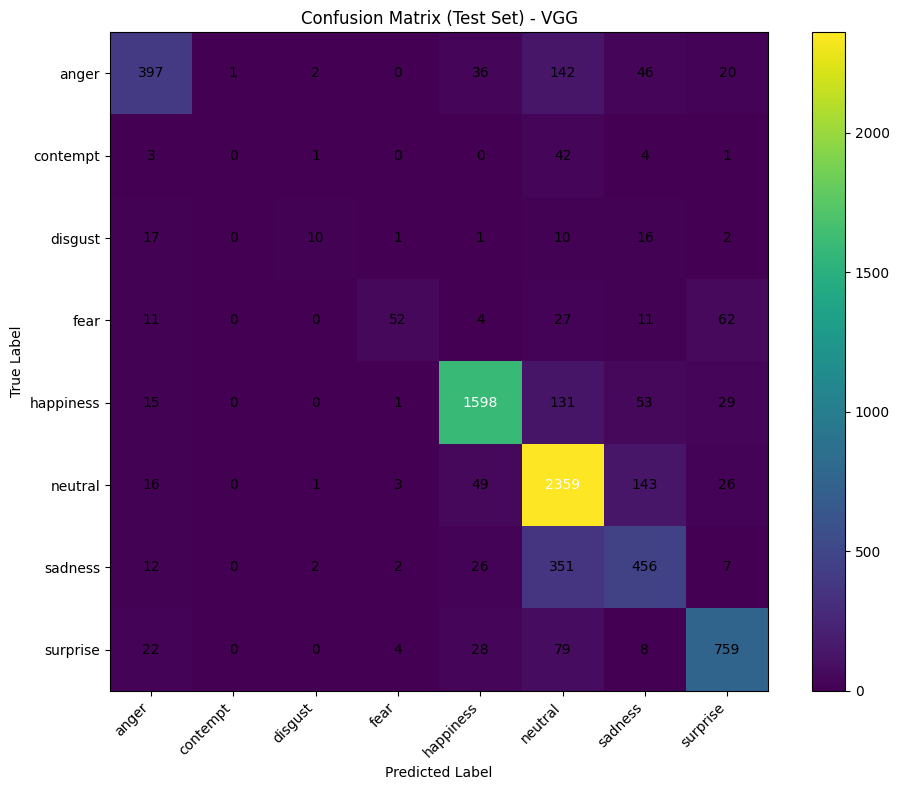

In [26]:
cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(10, 8))

# Display the confusion matrix as an image (heatmap-like)
# We are NOT setting colors manually (matplotlib default colormap is used)
plt.imshow(cm, interpolation='nearest')

# Add a title for the plot
plt.title("Confusion Matrix (Test Set) - VGG")

# Add a colorbar legend to show intensity scale
plt.colorbar()

# Set tick marks on x and y axes to match number of classes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")  # rotate x labels for readability
plt.yticks(tick_marks, class_names)

# Add numbers inside each cell for clarity (optional but useful)
# This helps you visually see counts (how many were classified correctly or incorrectly)
threshold = cm.max() / 2.0  # used to choose text color for visibility

for i in range(cm.shape[0]):              # loop over rows (true labels)
    for j in range(cm.shape[1]):          # loop over columns (predicted labels)
        plt.text(
            j, i, cm[i, j],               # place count at position (j,i)
            ha="center", va="center",
            color="white" if cm[i, j] > threshold else "black"
        )

# Label axes clearly
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Make layout tight so labels don't get cut off
plt.tight_layout()

# Finally show the plot
plt.show()

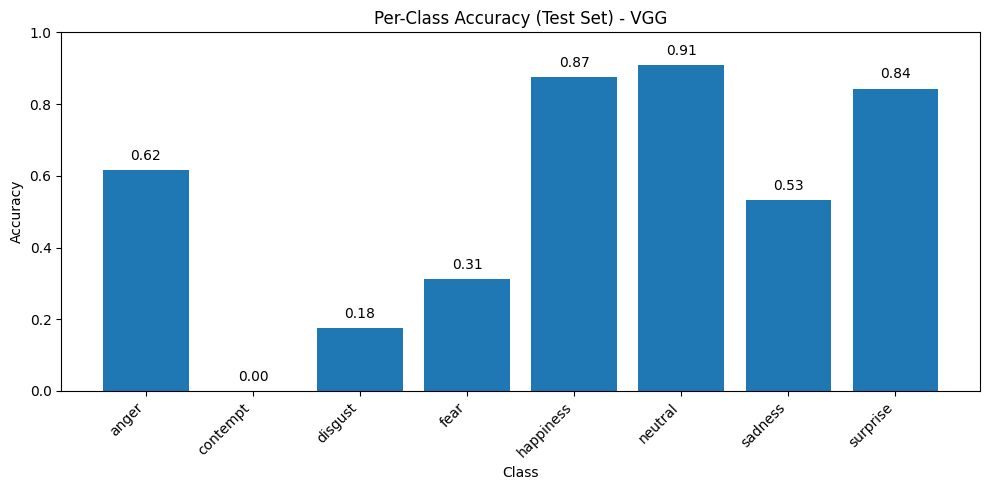

In [28]:
y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)

per_class_acc = []  # will store accuracy for each class

for class_idx in range(len(class_names)):
    # Find all samples that truly belong to this class
    mask = (y_true_test == class_idx)

    # Count how many samples exist for this class
    total_in_class = mask.sum()

    # If a class has zero samples (rare but possible), avoid division by zero
    if total_in_class == 0:
        acc = 0.0
    else:
        # Correct predictions are where y_pred equals y_true, but only inside this class subset
        correct_in_class = (y_pred_test[mask] == y_true_test[mask]).sum()
        acc = correct_in_class / total_in_class

    per_class_acc.append(acc)

per_class_acc = np.array(per_class_acc)

# Plot bar chart
plt.figure(figsize=(10, 5))

# x positions for bars
x = np.arange(len(class_names))

# Create bars
plt.bar(x, per_class_acc)

# Add title and labels
plt.title("Per-Class Accuracy (Test Set) - VGG")
plt.ylabel("Accuracy")
plt.xlabel("Class")

# Show class names under bars
plt.xticks(x, class_names, rotation=45, ha="right")

# Set y-axis limit from 0 to 1 because accuracy is a fraction
plt.ylim(0, 1)

# Add accuracy value above each bar
for i, acc in enumerate(per_class_acc):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()